## Model (Clustering or Association Rules)

* Team : Data Crew

(Clustering for the customers or finding patterns in the data with some association rulel algorithms)

* Libraries required

In [19]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librarie for Preprocessing
from utils import *

# Data Structures
from collections import defaultdict

# Model Libraries
from xgboost import XGBClassifier

# Import torch
import torch
import torch.nn as nn

# Model Selection and Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold

sns.set_style('whitegrid')

* Retrieving the data from the original source

In [20]:
data = pd.read_csv('../../1. Data/smaller_sample.csv')
event_defs = pd.read_csv('../../1. Data/Event+Definitions.csv')

* Data Cleaning and Feature Engineering

In [21]:
df = get_classification_dataset(data, event_defs, n_events=5)
df

,,num_journeys,max_journey,discover,approved_credit,first_purchase,account_activitation,downpayment_received,downpayment_cleared,order_ships,max_milestone,number_accounts,one_more_journey,most_repeated_event,average_length_seq,first_5_events
customer_id,,,,,,,,,,,,,,,,
5414,0,1,27,True,True,False,False,False,False,False,1.0,1,False,4,24.0,"[21, 12, 4, 2, 4]"
26746,0,1,5,True,True,False,False,False,False,False,1.0,1,False,2,3.0,"[2, 12, 21]"
43085,0,1,30,True,True,True,True,True,True,True,6.0,1,False,5,30.0,"[29, 2, 12, 4, 4]"
61659,0,1,7,True,True,False,False,False,False,False,1.0,1,False,4,7.0,"[12, 23, 4, 11, 6]"
67034,0,1,22,True,True,False,False,False,False,False,1.0,1,False,19,17.0,"[2, 19, 19, 19, 19]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147283220,0,1,12,True,True,False,False,False,False,False,1.0,1,False,4,11.0,"[12, 4, 4, 4, 4]"
2147340717,0,1,11,False,True,False,False,False,False,False,1.0,1,False,21,8.0,"[12, 24, 4, 11, 5]"
2147417277,0,1,15,False,True,False,False,False,False,False,1.0,1,False,3,13.0,"[12, 6, 11, 5, 4]"


### Selecting the customers with a certain amount of events

In [22]:
number_events_fixed = 5

lengths = df['first_5_events'].apply(lambda x: len(x))
print(lengths.value_counts())

first_5_events
5    70432
3     3765
4     3584
2     3335
1     2166
Name: count, dtype: int64


In [23]:
idxs = lengths[lengths == number_events_fixed].index
df_selected = df.loc[idxs]

### New dataset without the following columns:

* First 5 events
* max_milestone

In [38]:
df_prueba = df_selected.drop(columns=['first_5_events', 'max_milestone', 'downpayment_cleared', ])

### Change type of the column with the sequences

As this column contains arrays of the fixed specified length, we cannot parse it directly to our model.

In [25]:
class Embedding(nn.Module):
    def __init__(self, embedding_dim, n_events=5):
        super().__init__()
        self.fc1 = nn.Linear(n_events, embedding_dim, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(embedding_dim, embedding_dim, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [26]:
# Embed event id sequence into smaller dimension
event_id = df_selected.first_5_events
event_id = torch.tensor(event_id.to_list()).float()
emb = Embedding(5, 5)
event_id = emb(event_id)

In [27]:
event_id_df = pd.DataFrame(event_id.detach().numpy())
ori_dfx = df_selected.drop(columns='first_5_events').reset_index(drop=True)
new_dfx = pd.concat([ori_dfx, event_id_df], axis=1)
new_dfx

,num_journeys,max_journey,discover,approved_credit,first_purchase,account_activitation,downpayment_received,downpayment_cleared,order_ships,max_milestone,number_accounts,one_more_journey,most_repeated_event,average_length_seq,0,1,2,3,4
0,1,27,True,True,False,False,False,False,False,1.0,1,False,4,24.0,-4.261306,3.327847,0.350540,-3.718317,-1.501745
1,1,30,True,True,True,True,True,True,True,6.0,1,False,5,30.0,-4.792860,4.896102,-0.686426,-5.142914,-2.225156
2,1,7,True,True,False,False,False,False,False,1.0,1,False,4,7.0,-6.822255,0.757567,3.410783,-3.489207,-3.114748
3,1,22,True,True,False,False,False,False,False,1.0,1,False,19,17.0,-9.937324,-2.405315,8.086930,-3.202826,-6.360750
4,1,114,False,True,False,False,False,False,False,1.0,1,False,4,107.0,-9.994090,0.726175,7.747801,-4.278425,-5.750301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70427,1,12,True,True,False,False,False,False,False,1.0,1,False,4,11.0,-2.469985,1.956732,0.850081,-2.025314,-1.237146
70428,1,11,False,True,False,False,False,False,False,1.0,1,False,21,8.0,-6.994291,0.876310,3.171787,-3.707460,-3.098642
70429,1,15,False,True,False,False,False,False,False,1.0,1,False,3,13.0,-4.224214,2.169717,1.208083,-3.063178,-1.822502
70430,1,32,False,True,False,False,False,False,False,1.0,1,False,4,27.0,-2.104019,0.152879,1.631116,-0.900721,-1.210590


### Separating the data and the target

In this case we want the target to be **order_ships** as this is how we are defining a customer journey as successful or not.

In [39]:
df_final = df_prueba

In [40]:
y = df_final['order_ships'].to_numpy()
X = df_final.drop(columns=['order_ships']).to_numpy()

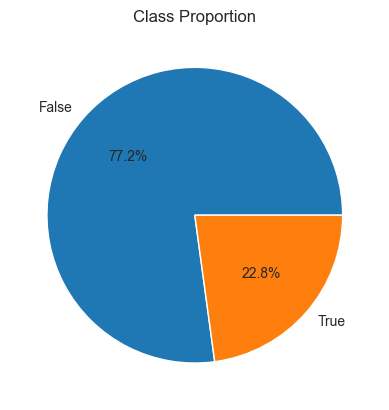

In [41]:
plt.pie(df_final['order_ships'].value_counts(), labels=df_final['order_ships'].value_counts().index, autopct='%1.1f%%')
plt.title('Class Proportion')
plt.show()

## XGBoost (First-Attempt Model)

### Simple Train-Test Split

In [42]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2024)

# Train the model
xgb = XGBClassifier(n_estimators=500, learning_rate=0.05, n_jobs=-1, random_state=2024)
xgb.fit(X_train, y_train)

# Predictions
y_pred = xgb.predict(X_test)

# Evaluate the model
print('Metrics : ')
print(classification_report(y_test, y_pred))

Metrics : 
              precision    recall  f1-score   support

       False       1.00      0.99      0.99     16357
        True       0.96      0.99      0.98      4773

    accuracy                           0.99     21130
   macro avg       0.98      0.99      0.99     21130
weighted avg       0.99      0.99      0.99     21130



<Axes: >

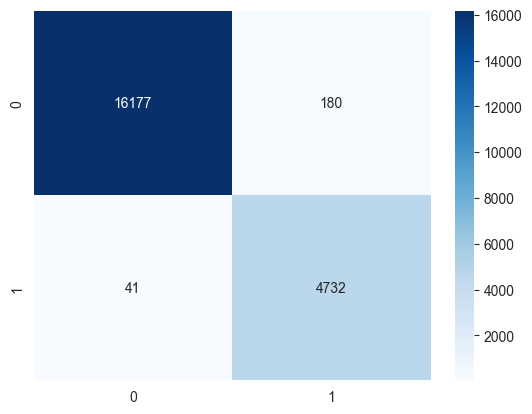

In [43]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

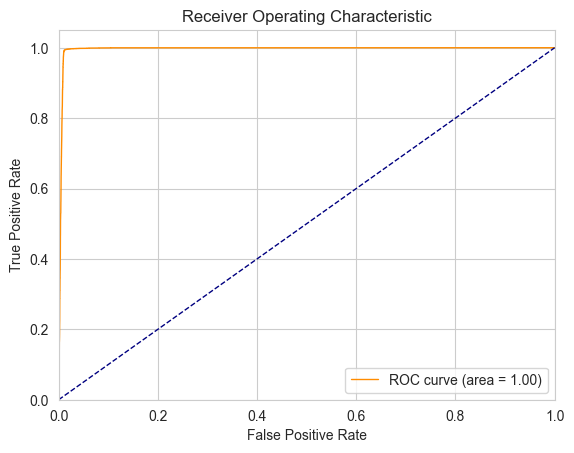

In [44]:
# roc curve
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Cross Validation

In [45]:
# Model
xgb = XGBClassifier(n_estimators=500,
                    learning_rate=0.05,
                    n_jobs=-1,
                    random_state=2024)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=2024)
scores = cross_val_score(xgb, X, y, cv=cv, scoring='f1')

print('Mean F1 score : ', scores.mean())
print('Std F1 : ', scores.std())

Mean F1 score :  0.9771016634993197
Std F1 :  0.002361444354744552


### Most Important Features

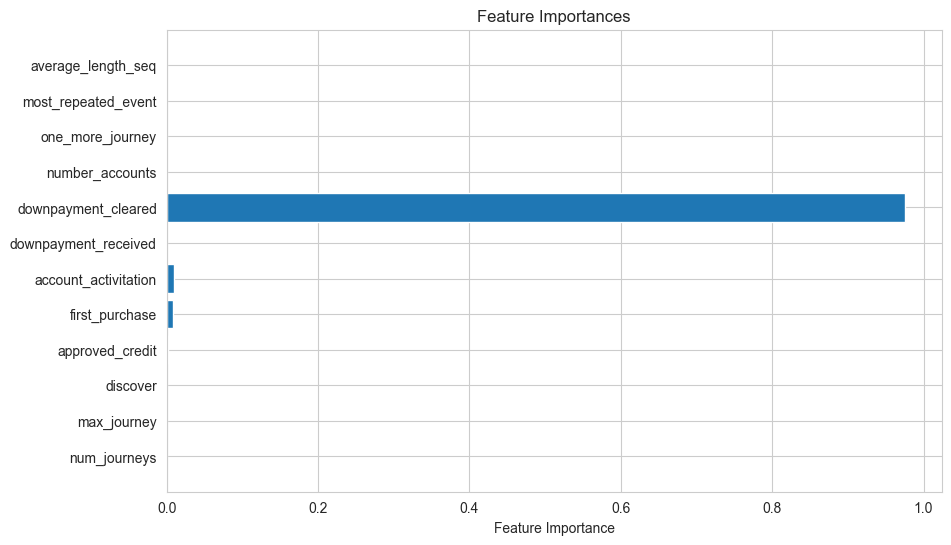

In [46]:
# Train the model
xgb = XGBClassifier(n_estimators=500, learning_rate=0.05, n_jobs=-1, random_state=2024)
xgb.fit(X,y)

# Columns
x = list(df_final.drop(columns=['order_ships']).columns)
x = [str(x_i) for x_i in x]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(x, xgb.feature_importances_)
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.show()